# Practical Exercise: Reconstructing the Z Boson!

It's time to apply what we've learned! In this exercise, we will perform a classic particle physics analysis: we will search for the Z boson (Z) from its decay into two muons $(Z \ to \ \mu+\mu−)$.
Objective: Create pairs of muons, calculate their invariant mass, and visualize the Z boson peak in a histogram.

In [1]:
import uproot
import awkward as ak
import numpy as np
import hist 
import particle, hepunits

### Step 1: Upload the relevant data

We already know how to open a file and access the TTree. But this time, we don't want all the branches (there could be hundreds).

Your task: Load only the branches we need for the muons: their transverse momentum (pt), eta, phi, and charge. Let's use the first 10,000 events to get good statistics.

Hint: The tree.arrays() method has a filter_name argument that accepts regular expressions (regex) to select branches by name.

In [3]:
file = uproot.open("root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root")

tree = file["Events"]

In [4]:
file.classnames()

{'Events;75': 'TTree', 'Events;74': 'TTree'}

In [5]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))


In [6]:
arrays = tree.arrays(filter_name="/Muon_(pt|eta|phi|charge)/", entry_stop = 10000)

We have the data in separate awkward arrays (arrays[“Muon_pt”], arrays[‘Muon_eta’], etc.). To work more comfortably, it is better to group them so that we have a list of “muons,” where each muon has all its properties together.

Your task: Use an awkward function to “compress” the separate arrays into a single array of muons.

Hint: What function allows us to combine several arrays into an array of records (structs)?

In [9]:
muons = ak.zip(
    {
        "pt": arrays["Muon_pt"],
        "eta": arrays["Muon_eta"],
        "phi": arrays["Muon_phi"],
        "charge": arrays["Muon_charge"],
    }

)

To see the difference, we can inspect the “type” of the arrays before and after ak.zip.

In [10]:
arrays.type

ArrayType(RecordType([ListType(NumpyType('float32')), ListType(NumpyType('float32')), ListType(NumpyType('float32')), ListType(NumpyType('int32'))], ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_charge']), 10000, None)

In [11]:
muons.type

ArrayType(ListType(RecordType([NumpyType('float32'), NumpyType('float32'), NumpyType('float32'), NumpyType('int32')], ['pt', 'eta', 'phi', 'charge'])), 10000, None)

### Step 3: Create muon pairs

To find the Z boson, we need to form all possible pairs of muons in each event.

Your task: Use an awkward function to generate combinations of 2 muons from your muons array.

Once you have the pairs, “unzip” them into two separate arrays: $\mu_1$ and $\mu_2$.

In [12]:
pairs = ak.combinations(muons, 2)

pairs.type

ArrayType(ListType(RecordType([RecordType([NumpyType('float32'), NumpyType('float32'), NumpyType('float32'), NumpyType('int32')], ['pt', 'eta', 'phi', 'charge']), RecordType([NumpyType('float32'), NumpyType('float32'), NumpyType('float32'), NumpyType('int32')], ['pt', 'eta', 'phi', 'charge'])], None)), 10000, None)

Quick check: Logically, the number of pairs in mu1 and mu2 should be identical for each event. Let's check it out!

In [ ]:
mu1, mu2 = ak.unzip(pairs)

num_pairs_mu1_per_event = ak.num(mu1, axis=1)
num_pairs_mu2_per_event = ak.num(mu2, axis=1)
print(f"Number of pairs in $\mu_1$ per event (first 10): {num_pairs_mu1_per_event[:10]}")
print(f"Number of pairs in $\mu_2$ per event (first 10): {num_pairs_mu2_per_event[:10]}")

In [16]:
are_lengths_equal_per_event = (num_pairs_mu1_per_event == num_pairs_mu2_per_event)
print(f"Are the lengths the same for each event (first 10)?: {are_lengths_equal_per_event[:10]}")

Are the lengths the same for each event (first 10)?: [True, True, True, True, True, True, True, True, True, True]


In [17]:
all_lengths_are_equal = ak.all(are_lengths_equal_per_event)
print(f"\nAre ALL lengths equal in mu1 and mu2 for each event?: {all_lengths_are_equal}")


Are ALL lengths equal in mu1 and mu2 for each event?: True


In [18]:
print(f"Total number of elements in $\mu_1$: {ak.num(mu1, axis=1)}")
print(f"Total number of elements in $\mu_2$: {ak.num(mu2, axis=1)}")

Total number of elements in $\mu_1$: [1, 1, 0, 6, 6, 3, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 3, 3, 6, 6, 1, 1, 1, 1, 1]
Total number of elements in $\mu_2$: [1, 1, 0, 6, 6, 3, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 3, 3, 6, 6, 1, 1, 1, 1, 1]


### Step 4: Calculate the Invariant Mass

Since they do have the same lengths, we will use the following formula to calculate the invariant mass of each pair of muons, assuming that their mass is negligible compared to their energy:

$\sqrt{2 * p_{T1} * p_{T2} \ (cosh(\eta_1 - \eta_2) - cos(\phi_1 - \phi_2))}$

Task: Apply this formula to your arrays $\mu_1$ and $\mu_2$.

Hint: Thanks to the magic of awkward, you can use numpy functions (np.sqrt, np.cosh, etc.) directly on awkward arrays. The operation will be applied to each pair.

In [20]:
mass = np.sqrt(
    2 * mu1.pt * mu2.pt * (np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))
)

### Step 5: Visualize! The first histogram

Now we have an array mass containing the invariant mass of each pair of muons in each event. Let's make a histogram of all these masses to see what we find.

Task: Create a histogram of the masses.

Hint: The hist library needs a flat (1D) array to be filled. Use ak.ravel() or ak.flatten() to “flatten” your array of masses.

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f915a12d250>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

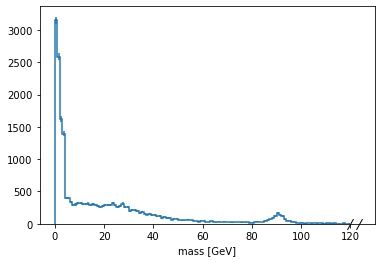

In [21]:
hist.Hist(hist.axis.Regular(120, 0, 120, label="mass [GeV]")).fill(ak.ravel(mass)).plot()

We're starting to see a peak around 90 GeV! But there's a lot of “noise” (background). Let's clean it up!

In [24]:
ak.max(mass, axis=1)

<Array [34.4, 27.9, None, 26.2, ..., 42.9, 0.252, 93.4] type='10000 * ?float32'>

Some values are None because there is no maximum of an empty list. ak.flatten/ak.ravel remove missing values (None) as well as squashing lists,

In [25]:
ak.flatten(ak.max(mass, axis=1), axis=0)

<Array [34.4, 27.9, 26.2, 18.2, ..., 42.9, 0.252, 93.4] type='8880 * float32'>

but so does removing the empty lists in the first place.

In [26]:
ak.max(mass[ak.num(mass) > 0], axis=1)

<Array [34.4, 27.9, 26.2, 18.2, ..., 42.9, 0.252, 93.4] type='8880 * ?float32'>

### Step 6: Apply physics cuts

We can improve our result by applying cuts based on our requirements for the analysis.

Task 1: Opposite Charge Cut The Z boson (electrically neutral), so it must decay into oppositely charged muons ($\mu+\mu−$). 
        Filter out the pairs to keep only those where mu1.charge is different from mu2.charge.

In [27]:
cut = (mu1.charge != mu2.charge)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f914c4e71d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

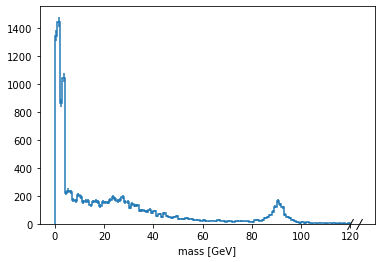

In [28]:
hist.Hist(hist.axis.Regular(120, 0, 120, label="mass [GeV]")).fill(ak.ravel(mass[cut])).plot()

Much better! The background noise has decreased significantly.

Task 2: Select the “Best” Pair In events with more than one valid pair, a common technique is to keep only the pair whose invariant mass is closest to the known mass of the Z (~91.2 GeV).

In [33]:
zmass = particle.Particle.findall("Z0")[0].mass / hepunits.GeV
zmass

91.188

In [34]:
which = ak.argmin(abs(mass - zmass), axis=1, keepdims=True)

In [35]:
histogram_data = ak.ravel(mass[which])
histogram_data_cleaned = ak.drop_none(histogram_data)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f914c278ad0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

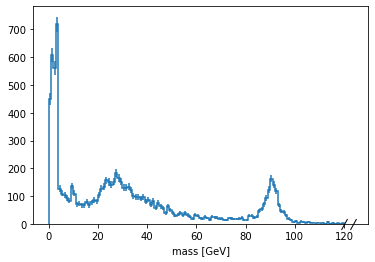

In [36]:
hist.Hist(hist.axis.Regular(120, 0, 120, label="mass [GeV]")).fill(histogram_data_cleaned).plot()

Congratulations! You have just performed your first physics analysis, from reading the data to reconstructing a particle and visualizing it. All of these steps are the foundation of what you will do with more advanced tools such as pocket-coffea.